In [2]:
import glob
import tqdm
import scipy
import pandas as pd
import numpy as np
import nibabel as nb
import itertools
import multiprocessing
import nibabel.processing
from nilearn import plotting
import matplotlib.pyplot as plt

# Spatial correlations within and across subjects

In [10]:
# construct cerebellar masks
nii_cereb = nb.load('../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1/fROIs_cerebellum_only_symmetrical.nii')
vol_cereb = nii_cereb.get_fdata()
# construct binary mask for LH and RH
left_cerebellum_mask = np.zeros(vol_cereb.shape, dtype=bool)
for i in [5,6,7,8]:
    mask_roi = (vol_cereb == i)
    left_cerebellum_mask = np.logical_or(left_cerebellum_mask, mask_roi)
right_cerebellum_mask = np.zeros(vol_cereb.shape, dtype=bool)
for i in [1,2,3,4]:
    mask_roi = (vol_cereb == i)
    right_cerebellum_mask = np.logical_or(right_cerebellum_mask, mask_roi)
left_cerebellum_mask = left_cerebellum_mask.flatten()
right_cerebellum_mask = right_cerebellum_mask.flatten()

In [11]:
nii_cortex = nb.load('/mindhive/evlab/u/Shared/ROIS_Nov2020/Func_Lang_LHRH_SN220/allParcels_language.nii')
vol_cortex = nii_cortex.get_fdata()
# construct binary mask for LH and RH
left_cortex_mask = np.zeros(vol_cortex.shape, dtype=bool)
for i in [1,2,3,4,5]:
    mask_roi = (vol_cortex == i)
    left_cortex_mask = np.logical_or(left_cortex_mask, mask_roi)
right_cortex_mask = np.zeros(vol_cortex.shape, dtype=bool)
for i in [7,8,9,10,11]:
    mask_roi = (vol_cortex == i)
    right_cortex_mask = np.logical_or(right_cortex_mask, mask_roi)
left_cortex_mask = left_cortex_mask.flatten()
right_cortex_mask = right_cortex_mask.flatten()

In [40]:
# compute spatial correlations!
files = sorted(glob.glob('../sessions/nii/*.nii'))
files_ODD = sorted(glob.glob('../sessions/nii_ODD/*.nii'))
files_EVEN = sorted(glob.glob('../sessions/nii_EVEN/*.nii'))

# remove 3 subjects without 2 runs from files
df = pd.read_csv('../sessions/final_lang_atlas_sessions.csv')
remove = df.loc[df.Runs<2,:].Session.values.tolist()
coverage = pd.read_csv('../coverage/LanA_cerebellar_coverage.csv')
remove = coverage.loc[(coverage.Runs<2) | (coverage.CerebellumVoxelsMissing>=50),:].Session.values.tolist()
print(len(remove))
files = sorted([file for file in files if file.split('/')[-1].split('PL2017')[0]+'PL2017' not in remove])
files_ODD = sorted([file for file in files_ODD if file.split('/')[-1].split('PL2017')[0]+'PL2017' not in remove])
files_EVEN = sorted([file for file in files_EVEN if file.split('/')[-1].split('PL2017')[0]+'PL2017' not in remove])
assert(len(files)==len(files_ODD))

# files = files[:10]
# files_ODD = files_ODD[:10]
# files_EVEN = files_EVEN[:10]

cov_cereb_right = np.zeros((len(files)*2,np.sum(right_cerebellum_mask)))
cov_cereb_left = np.zeros((len(files)*2,np.sum(left_cerebellum_mask)))
cov_cereb_whole = np.zeros((len(files)*2,np.sum(right_cerebellum_mask)+np.sum(left_cerebellum_mask)))
cov_cortex_right = np.zeros((len(files)*2,np.sum(right_cortex_mask)))
cov_cortex_left = np.zeros((len(files)*2,np.sum(left_cortex_mask)))
cov_cortex_whole = np.zeros((len(files)*2,np.sum(right_cortex_mask)+np.sum(left_cortex_mask)))

row = 0
for r,(f1,f1_ODD,f1_EVEN) in tqdm.tqdm(enumerate(zip(files,files_ODD,files_EVEN))):
    f1_session = f1_ODD.split('/')[-1].split('PL2017')[0]+'PL2017'
    f1_vol = nb.load(f1_ODD).get_fdata().flatten()

    cov_cereb_right[row,:] = f1_vol[right_cerebellum_mask]
    cov_cereb_left[row,:] = f1_vol[left_cerebellum_mask]
    cov_cereb_whole[row,:] = np.concatenate((f1_vol[right_cerebellum_mask], f1_vol[left_cerebellum_mask]))
    cov_cortex_right[row,:] = f1_vol[right_cortex_mask]
    cov_cortex_left[row,:] = f1_vol[left_cortex_mask]
    cov_cortex_whole[row,:] = np.concatenate((f1_vol[right_cortex_mask], f1_vol[left_cortex_mask]))

    row = row+1
    
    f2_session = f1_EVEN.split('/')[-1].split('PL2017')[0]+'PL2017'
    f2_vol = nb.load(f1_EVEN).get_fdata().flatten()
    
    cov_cereb_right[row,:] = f2_vol[right_cerebellum_mask]
    cov_cereb_left[row,:] = f2_vol[left_cerebellum_mask]
    cov_cereb_whole[row,:] = np.concatenate((f2_vol[right_cerebellum_mask], f2_vol[left_cerebellum_mask]))
    cov_cortex_right[row,:] = f2_vol[right_cortex_mask]
    cov_cortex_left[row,:] = f2_vol[left_cortex_mask]
    cov_cortex_whole[row,:] = np.concatenate((f2_vol[right_cortex_mask], f2_vol[left_cortex_mask]))

    row = row+1

sessions_ODD = [f1.split('/')[-1].split('PL2017')[0]+'PL2017_ODD' for f1 in files_ODD]
sessions_EVEN = [f1.split('/')[-1].split('PL2017')[0]+'PL2017_EVEN' for f1 in files_EVEN]
sessions = [val for pair in zip(sessions_ODD, sessions_EVEN) for val in pair]

# save data
cols = ['voxel'+str(i+1) for i in np.arange(0,cov_cereb_right.shape[1])]
pd.DataFrame(cov_cereb_right, index=sessions, columns=cols).to_csv('S-N_data_right_lang_cerebellum.csv')
cols = ['voxel'+str(i+1) for i in np.arange(0,cov_cereb_left.shape[1])]
pd.DataFrame(cov_cereb_left, index=sessions, columns=cols).to_csv('S-N_data_left_lang_cerebellum.csv')
cols = ['voxel'+str(i+1) for i in np.arange(0,cov_cereb_right.shape[1]+cov_cereb_left.shape[1])]
pd.DataFrame(cov_cereb_whole, index=sessions, columns=cols).to_csv('S-N_data_whole_lang_cerebellum.csv')
cols = ['voxel'+str(i+1) for i in np.arange(0,cov_cortex_right.shape[1])]
pd.DataFrame(cov_cortex_right, index=sessions, columns=cols).to_csv('S-N_data_right_lang_cortex.csv')
cols = ['voxel'+str(i+1) for i in np.arange(0,cov_cortex_left.shape[1])]
pd.DataFrame(cov_cortex_left, index=sessions, columns=cols).to_csv('S-N_data_left_lang_cortex.csv')
cols = ['voxel'+str(i+1) for i in np.arange(0,cov_cortex_right.shape[1]+cov_cortex_left.shape[1])]
pd.DataFrame(cov_cortex_whole, index=sessions, columns=cols).to_csv('S-N_data_whole_lang_cortex.csv')

# save covariance matrices
pd.DataFrame(np.cov(cov_cereb_right), index=sessions, columns=sessions).to_csv('S-N_cov_right_lang_cerebellum.csv')
pd.DataFrame(np.cov(cov_cereb_left), index=sessions, columns=sessions).to_csv('S-N_cov_left_lang_cerebellum.csv')
pd.DataFrame(np.cov(cov_cereb_whole), index=sessions, columns=sessions).to_csv('S-N_cov_whole_lang_cerebellum.csv')
pd.DataFrame(np.cov(cov_cortex_right), index=sessions, columns=sessions).to_csv('S-N_cov_right_lang_cortex.csv')
pd.DataFrame(np.cov(cov_cortex_left), index=sessions, columns=sessions).to_csv('S-N_cov_left_lang_cortex.csv')
pd.DataFrame(np.cov(cov_cortex_whole), index=sessions, columns=sessions).to_csv('S-N_cov_whole_lang_cortex.csv')

52


754it [00:06, 122.44it/s]


In [41]:
regions = [
    'right_lang_cerebellum',
    'left_lang_cerebellum',
    'whole_lang_cerebellum',
    'right_lang_cortex',
    'left_lang_cortex',
    'whole_lang_cortex'
]

In [42]:
summary = pd.DataFrame()
within_subject = []
within_subject_percent = []
between_subjects = []
between_subjects_percent = []
for region in regions:
    cov = pd.read_csv('S-N_cov_'+region+'.csv',index_col=0)
    
    within = np.diagonal(cov, offset=1)
    between = np.triu(cov, k=2)

    within_subject.append(np.mean(within))
    within_subject_percent.append(np.mean(within)/(np.mean(within)+np.mean(between)))
    between_subjects.append(np.mean(between))
    between_subjects_percent.append(np.mean(between)/(np.mean(within)+np.mean(between)))

summary['within_subject'] = within_subject
summary['within_subject_percent'] = within_subject_percent
summary['between_subjects'] = between_subjects
summary['between_subjects_percent'] = between_subjects_percent
summary.index = regions
summary.to_csv('cov_summary.csv')
summary.head()

,within_subject,within_subject_percent,between_subjects,between_subjects_percent
right_lang_cerebellum,0.593184,0.935183,0.041114,0.064817
left_lang_cerebellum,0.256824,0.936610,0.017382,0.063390
whole_lang_cerebellum,0.576904,0.872712,0.084144,0.127288
right_lang_cortex,0.980047,0.861769,0.157203,0.138231
left_lang_cortex,2.205900,0.892597,0.265427,0.107403


In [43]:
for region in regions:
    data = pd.read_csv('S-N_data_'+region+'.csv',index_col=0)
    corrs = np.corrcoef(data.values)
    pd.DataFrame(corrs, index=data.index, columns=data.index).to_csv('S-N_corrs_'+region+'.csv')

In [44]:
# repeat for correlation coefficients instead of covariance
summary = pd.DataFrame()
within_subject = []
within_subject_percent = []
between_subjects = []
between_subjects_percent = []
for region in regions:
    cov = pd.read_csv('S-N_corrs_'+region+'.csv',index_col=0)
    
    within = np.diagonal(cov, offset=1)
    between = np.triu(cov, k=2)

    within_subject.append(np.mean(within))
    within_subject_percent.append(np.mean(within)/(np.mean(within)+np.mean(between)))
    between_subjects.append(np.mean(between))
    between_subjects_percent.append(np.mean(between)/(np.mean(within)+np.mean(between)))

summary['within_subject'] = within_subject
summary['within_subject_percent'] = within_subject_percent
summary['between_subjects'] = between_subjects
summary['between_subjects_percent'] = between_subjects_percent
summary.index = regions
summary.to_csv('corrs_summary.csv')
summary.head()

,within_subject,within_subject_percent,between_subjects,between_subjects_percent
right_lang_cerebellum,0.283268,0.929758,0.021400,0.070242
left_lang_cerebellum,0.172350,0.927895,0.013393,0.072105
whole_lang_cerebellum,0.285817,0.867123,0.043798,0.132877
right_lang_cortex,0.332314,0.851560,0.057928,0.148440
left_lang_cortex,0.430919,0.888740,0.053946,0.111260


In [82]:
summary = pd.DataFrame()
for region in regions:
    corrs = pd.read_csv('S-N_corrs_'+region+'.csv',index_col=0)
    within = np.zeros((int(corrs.shape[0]/2),))
    between = np.zeros((int(corrs.shape[0]/2),))

    row = 0
    for i in range(0,corrs.shape[0],2):
        within[row] = corrs.iloc[i,i+1]
        between_curr = np.concatenate((corrs.iloc[i,(i+2):].values, corrs.iloc[:i,i].values,
                                       corrs.iloc[i+1,(i+2):].values, corrs.iloc[:i,i+1].values))
        assert(len(between_curr)==((corrs.shape[0]-2)*2))
        between[row] = np.mean(between_curr)
        row = row+1

    summary[region+'_within_subject'] = within
    summary[region+'_between_subjects'] = between

coverage = pd.read_csv('../coverage/LanA_cerebellar_coverage.csv')
sessions = coverage.loc[(coverage.Runs>=2) & (coverage.CerebellumVoxelsMissing<50),:].Session.values.tolist()
summary.index = sessions
summary.to_csv('spcorrs_summary_revision.csv')
summary.head()

,right_lang_cerebellum_within_subject,right_lang_cerebellum_between_subjects,left_lang_cerebellum_within_subject,left_lang_cerebellum_between_subjects,whole_lang_cerebellum_within_subject,whole_lang_cerebellum_between_subjects,right_lang_cortex_within_subject,right_lang_cortex_between_subjects,left_lang_cortex_within_subject,left_lang_cortex_between_subjects,whole_lang_cortex_within_subject,whole_lang_cortex_between_subjects
001_SWJN_01_PL2017,0.605803,0.017481,0.443140,0.046498,0.555853,0.096997,0.641203,0.155520,0.742832,0.100286,0.730715,0.196683
002_SWJN_05_PL2017,0.320650,-0.012882,-0.084576,0.007630,0.167537,0.042328,0.132487,0.101261,0.640780,0.117153,0.481487,0.168838
003_SWJN_07_PL2017,0.380470,0.032776,-0.013449,-0.020041,0.194939,0.064713,0.220699,0.164004,0.623701,0.094159,0.489555,0.165515
004_SWJN_09_PL2017,0.764262,0.050648,0.646524,0.039453,0.720965,0.058850,0.825209,0.150470,0.831750,0.103913,0.828897,0.116208
005_SWJN_11_PL2017,0.385680,0.027328,0.322586,0.009783,0.386102,0.075273,0.346522,0.023706,0.541240,0.088849,0.475654,0.096587


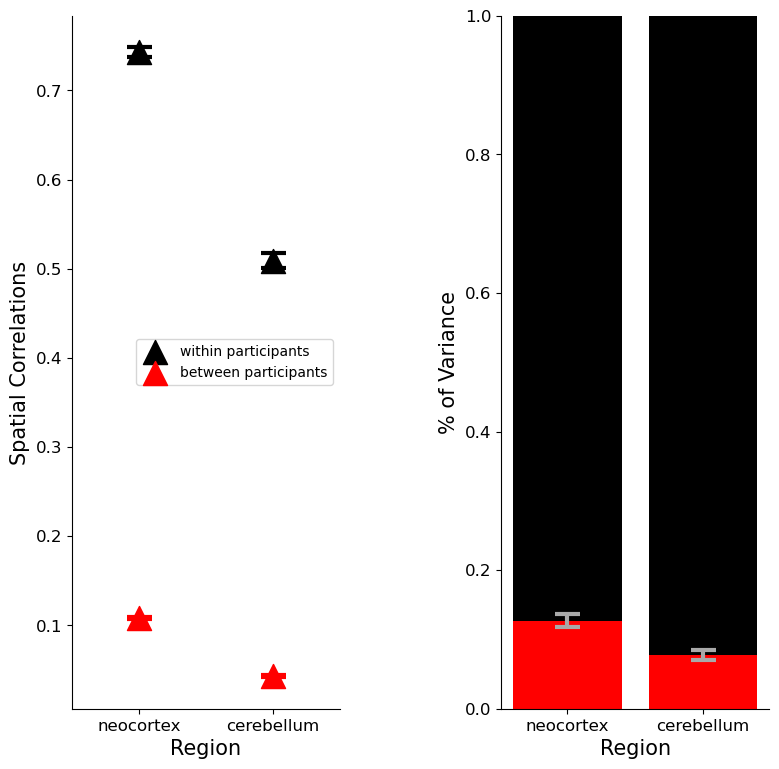

In [102]:
# plot 
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
plt.rc('font',**{'family':'sans-serif'})
plt.rc('pdf', **{'fonttype':42})
fig = plt.figure(figsize=(9,9))
fig.subplots_adjust(hspace=0.6, wspace=0.6)

corrs = pd.read_csv('spcorrs_summary_revision.csv',index_col=0)

within_cereb = corrs['right_lang_cerebellum_within_subject']
between_cereb = corrs['right_lang_cerebellum_between_subjects']

within_cortex = corrs['left_lang_cortex_within_subject']
between_cortex = corrs['left_lang_cortex_between_subjects']

# corrs_cortex = pd.read_csv('S-N_corrs_left_lang_cortex.csv',index_col=0)
# within_cortex = np.diagonal(corrs_cortex, offset=1)
# between_cortex = np.triu(corrs_cortex, k=2)

ax = fig.add_subplot(1,2,1)
plt.scatter([1,2],[np.mean(within_cortex),np.mean(within_cereb)],300,'k',marker="^")
plt.errorbar([1,2],[np.mean(within_cortex),np.mean(within_cereb)],
            yerr=[np.nanstd(within_cortex)/np.sqrt(len(within_cortex)),
                  np.nanstd(within_cereb)/np.sqrt(len(within_cereb))],
            capsize=9, elinewidth=3, capthick=3, ecolor='k', fmt='none')
plt.scatter([1,2],[np.mean(between_cortex),np.mean(between_cereb)],300,'r',marker="^")
plt.errorbar([1,2],[np.mean(between_cortex),np.mean(between_cereb)],
            yerr=[np.nanstd(between_cortex)/np.sqrt(len(between_cortex)),
                  np.nanstd(between_cereb)/np.sqrt(len(between_cereb))],
            capsize=9, elinewidth=3, capthick=3, ecolor='r', fmt='none')
ax.legend(['within participants','between participants'],fontsize=10)
plt.rc('ytick', labelsize=12)
plt.rc('xtick', labelsize=12)
ax.set_xlim([0.5,2.5])
ax.set_xticks([1,2])
ax.set_xticklabels(['neocortex','cerebellum'])
ax.set_xlabel('Region',fontsize=15)
ax.set_ylabel('Spatial Correlations',fontsize=15)

ax = fig.add_subplot(1,2,2)
plt.bar(1,np.mean(between_cortex)/(np.mean(within_cortex)+np.mean(between_cortex)),color='r',
        yerr=np.std(between_cortex/(within_cortex+between_cortex))/np.sqrt(len(between_cortex)), ecolor='darkgrey', capsize=9, error_kw={'elinewidth' : 3, 'capthick' : 3})
plt.bar(1,np.mean(within_cortex)/(np.mean(within_cortex)+np.mean(between_cortex)), bottom=np.mean(between_cortex)/(np.mean(within_cortex)+np.mean(between_cortex)),color='k')
plt.bar(2,np.mean(between_cereb)/(np.mean(within_cereb)+np.mean(between_cereb)),color='r',
        yerr=np.std(between_cereb/(within_cereb+between_cereb))/np.sqrt(len(between_cereb)), ecolor='darkgrey', capsize=9, error_kw={'elinewidth' : 3, 'capthick' : 3})
plt.bar(2,np.mean(within_cereb)/(np.mean(within_cereb)+np.mean(between_cereb)), bottom=np.mean(between_cereb)/(np.mean(within_cereb)+np.mean(between_cereb)),color='k')
plt.rc('ytick', labelsize=12)
plt.rc('xtick', labelsize=12)
ax.set_xticks([1,2])
ax.set_xticklabels(['neocortex','cerebellum'])
ax.set_xlabel('Region',fontsize=15)
ax.set_ylim([0,1])
ax.set_ylabel('% of Variance',fontsize=15)

save_filename = 'cortex_vs_cerebellum_revision.pdf'
plt.savefig(save_filename,format='pdf',bbox_inches='tight',pad_inches=0.5) 

In [106]:
# run stats
cereb_vals = between_cereb/(within_cereb+between_cereb)
cortex_vals = between_cortex/(within_cortex+between_cortex)
results = scipy.stats.wilcoxon(cortex_vals, cereb_vals)
print(results.pvalue)

1.1846708004117155e-50


In [107]:
print(np.mean(cereb_vals))
print(np.mean(cortex_vals))

0.08620279926808166
0.1374122819671911


In [3]:
corrs = pd.read_csv('spcorrs_summary_revision.csv',index_col=0)
within_cortex = corrs['left_lang_cortex_within_subject']
np.mean(within_cortex)

0.7428130968787342